# Panaroma and Feature Matching

In [2]:
%matplotlib inline
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import plotly
from skimage import io
from skimage import morphology as morp
import plotly.express as px
import plotly.graph_objects as go
path = './Day4 Material/'

In [3]:
book1_points = np.array([[141, 131], [480, 159], [493, 630],[64, 601]], dtype=float)
book2_points = np.array([[318, 256],[534, 372],[316, 670],[73, 473]], dtype=float)

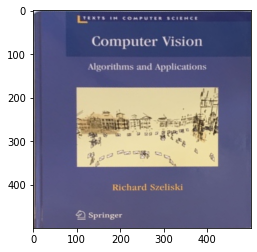

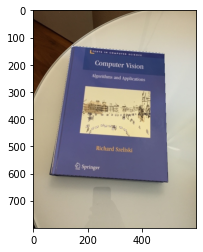

In [21]:
book1 = cv2.cvtColor(cv2.imread(path+'book1.jpg'),cv2.COLOR_BGR2RGB)
book2 = cv2.cvtColor(cv2.imread(path+'book2.jpg'),cv2.COLOR_BGR2RGB)
pts1 = book1_points
pts2 = book2_points
pts_trans = np.array([[0,0],[500,0],[500,500],[0,500]],dtype=float)
H1, status = cv2.findHomography(pts2, pts_trans)
im_tmp = cv2.warpPerspective(book1, H1, (500,500))
plt.figure()
plt.imshow(im_tmp)
H2, status = cv2.findHomography(pts_trans, pts1)
im_dst = cv2.warpPerspective(im_tmp, H2, (book2.shape[1],book2.shape[0]))
final = np.copy(book2)
final[np.where((im_dst[:,:,0]!=0)&(im_dst[:,:,1]!=0)&(im_dst[:,:,0]!=0))] = im_dst[np.where((im_dst[:,:,0]!=0)&(im_dst[:,:,1]!=0)&(im_dst[:,:,0]!=0))]
plt.figure()
plt.imshow(final)

<ipython-input-20-3a710210e33c>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


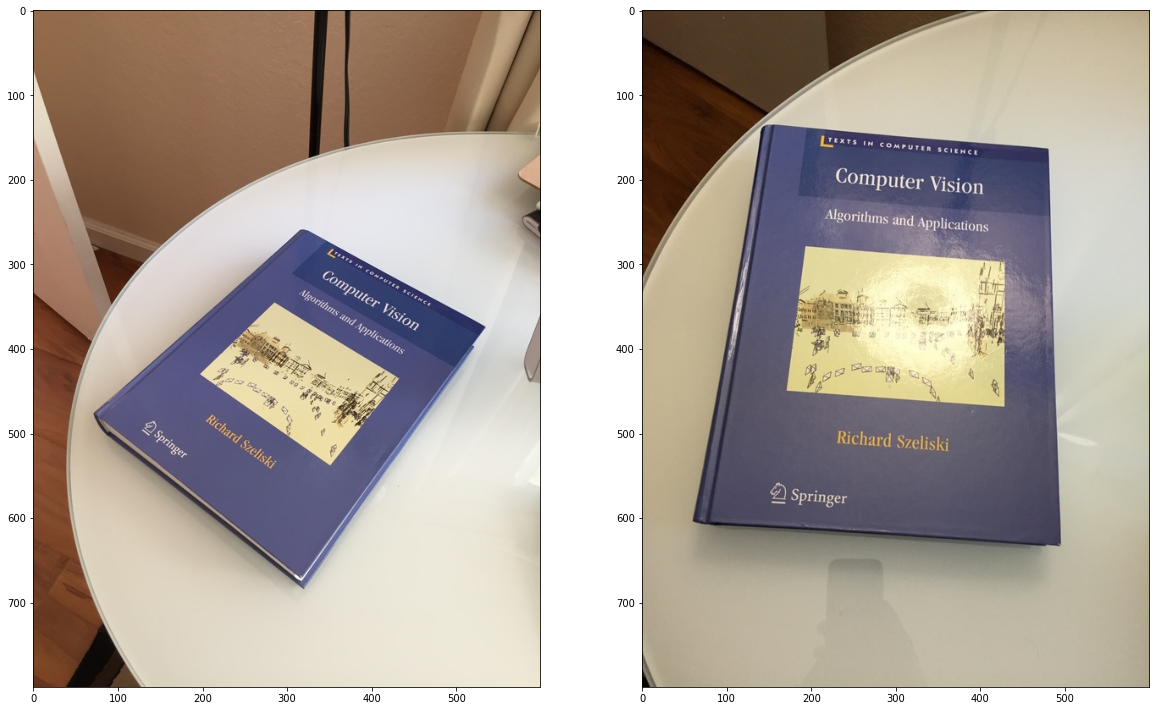

In [20]:
%matplotlib inline
fig,axes = plt.subplots(1,2,figsize=[20,20])
axes[0].imshow(book1)
axes[1].imshow(book2)
fig.show()

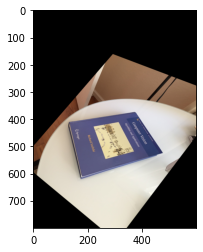

In [24]:
book1 = cv2.cvtColor(cv2.imread(path+'book1.jpg'),cv2.COLOR_BGR2RGB)
book2 = cv2.cvtColor(cv2.imread(path+'book2.jpg'),cv2.COLOR_BGR2RGB)
pts1 = book1_points
pts2 = book2_points
H2, status = cv2.findHomography(pts1, pts2)
im_dst = cv2.warpPerspective(book1, H2, (book2.shape[1],book2.shape[0]))
plt.figure()
plt.imshow(im_dst)

## parallelly calibrated cameras
$$
Z = \frac{T\cdot f}{x_l - x_r}
$$
$x_l - x_r$ is disparity.

$T$ is baseline

$f$ is focal length

![](pcc.png)

In [36]:
tsukuba_l = cv2.imread(path+'tsukuba_l.png',cv2.IMREAD_UNCHANGED)
tsukuba_r = cv2.imread(path+'tsukuba_r.png',cv2.IMREAD_UNCHANGED)

<ipython-input-39-d46de879dacb>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


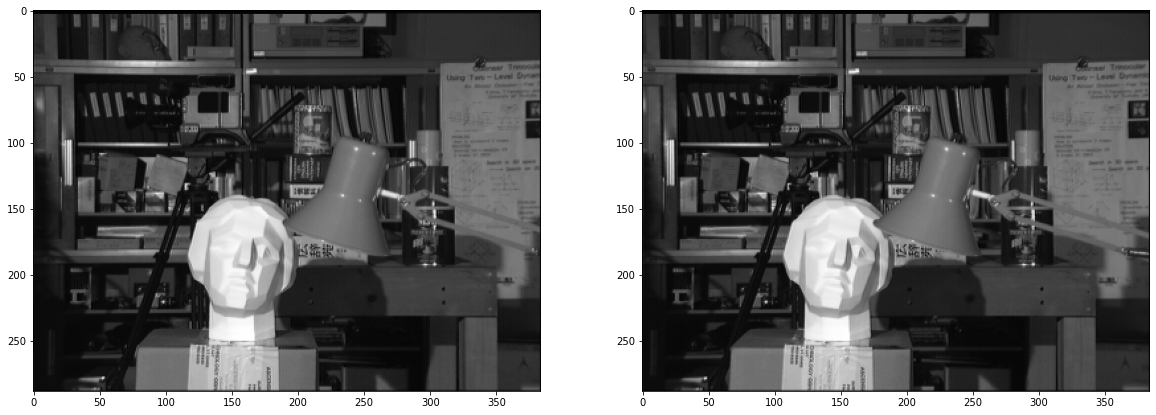

In [39]:
%matplotlib inline
fig,axes = plt.subplots(1,2,figsize=[20,20])
axes[0].imshow(tsukuba_l,cmap='gray')
axes[1].imshow(tsukuba_r,cmap='gray')
fig.show()

In [40]:
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity_map = stereo.compute(tsukuba_l, tsukuba_r).astype(np.float32)
print(np.max(disparity_map),np.min(disparity_map))

240.0 -16.0


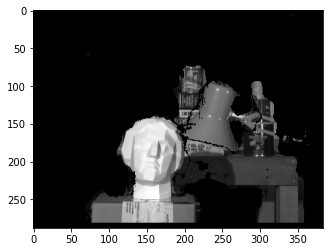

In [53]:
l_copy = np.copy(tsukuba_l)
l_copy[np.where(disparity_map<110)] = 0
plt.imshow(l_copy,cmap='gray')

In [60]:
view_0 = cv2.cvtColor(cv2.imread(path+'view0.png'),cv2.COLOR_BGR2RGB)
view_1 = cv2.cvtColor(cv2.imread(path+'view1.png'),cv2.COLOR_BGR2RGB)
view0_gray = cv2.cvtColor(view_0,cv2.COLOR_RGB2GRAY)
view1_gray = cv2.cvtColor(view_1,cv2.COLOR_RGB2GRAY)

<ipython-input-61-ab994c68ea42>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-61-ab994c68ea42>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


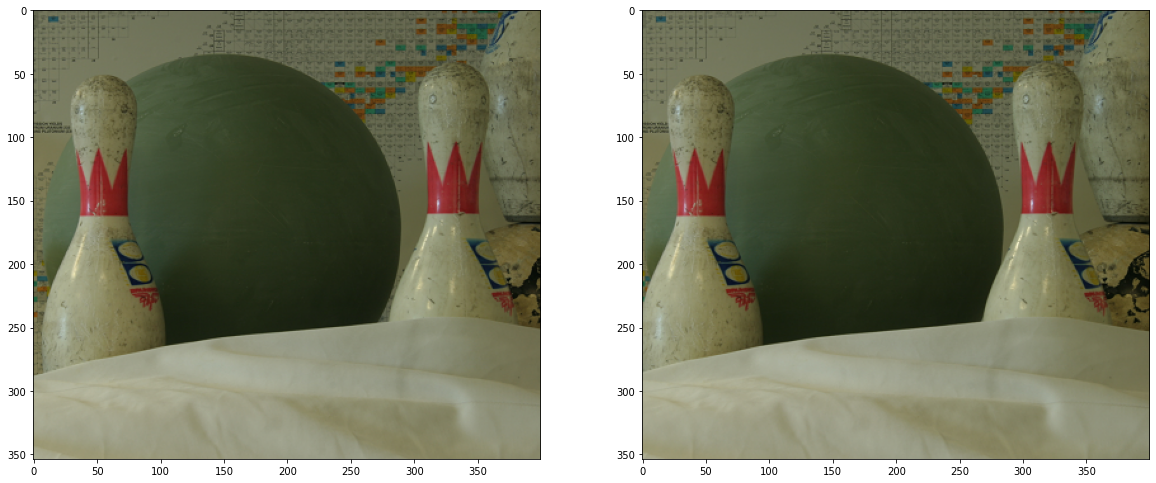

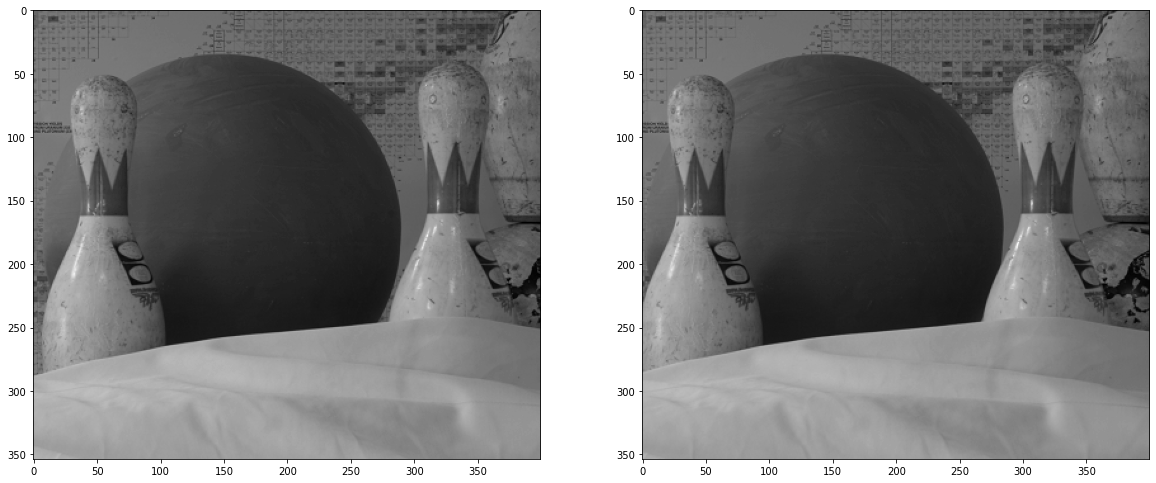

In [61]:
%matplotlib inline
fig,axes = plt.subplots(1,2,figsize=[20,20])
axes[0].imshow(view_0,cmap='gray')
axes[1].imshow(view_1,cmap='gray')
fig.show()
fig,axes = plt.subplots(1,2,figsize=[20,20])
axes[0].imshow(view0_gray,cmap='gray')
axes[1].imshow(view1_gray,cmap='gray')
fig.show()

In [62]:
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity_map = stereo.compute(view0_gray, view1_gray).astype(np.float32)
print(np.max(disparity_map),np.min(disparity_map))

240.0 -16.0


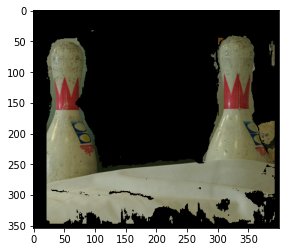

In [70]:
v0_copy = np.copy(view_0)
v0_copy[np.where(disparity_map<150)] = 0
plt.imshow(v0_copy)

# Patch matching

![](patch matching.png)

![](cost metrics.png)

In [141]:
def stereo_match(left_img, right_img, kernel, max_offset):
    w, h = left_img.shape  # assume that both images are same size   
    
    left = np.asarray(left_img)
    right = np.asarray(right_img)
    # Depth (or disparity) map
    depth = np.zeros((w, h), np.uint8)
    depth.shape = h, w
       
    kernel_half = int(kernel / 2)    
    offset_adjust = 255 / max_offset
      
    for y in range(kernel_half, h - kernel_half):      
        print(".", end="", flush=True)
        
        for x in range(kernel_half, w - kernel_half):
            best_offset = 0
            prev_ssd = 65534
            
            for offset in range(max_offset):               
                ssd = 0
                ssd_temp = 0
                flag = 1
                for v in range(-kernel_half, kernel_half):
                    for u in range(-kernel_half, kernel_half):
                        try:
                            ssd_temp = int(left[y+v, x+u]) - int(right[y+v, (x+u) - offset])  
                            ssd += ssd_temp * ssd_temp
                            flag = 1
                        except:
                            flag = 0
                if ssd < prev_ssd:
                    prev_ssd = ssd
                    best_offset = offset
                    flag = 0
                            
            depth[y, x] = best_offset * offset_adjust
                                
    return depth

In [142]:
stereo_match(view0_gray, view1_gray, 6, 30)  # 6x6 local search kernel, 30 pixel search range

..........................................................................................................................................................................................................................................................................................................................................................................................................

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

NameError: name 'y' is not defined

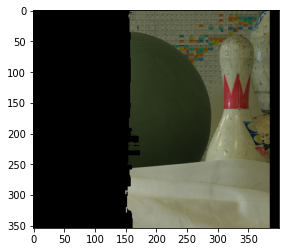

In [143]:
v0_copy = np.copy(view_0)
v0_copy[np.where(disp_map>-150)] = 0
plt.imshow(v0_copy)

In [87]:
x_r.shape

(354, 400)

In [83]:
x_r[i:i+blockSize,k:k+blockSize]

array([[ 97,  97,  93,  99, 105,  94, 108, 112, 113, 116, 104, 102, 102,
         99, 111],
       [ 98,  98,  93, 104,  96,  99, 106, 113, 113, 114, 105, 101,  99,
        102, 100],
       [ 98,  98,  94, 110, 116, 115, 114, 113, 113, 114, 105, 112, 115,
        114, 114],
       [ 99,  98,  94, 110, 113, 114, 113, 115, 115, 114, 107, 112, 114,
        113, 114],
       [ 79,  94,  93, 108, 112, 102,  98,  92, 103, 114, 106, 113, 117,
        108, 109],
       [ 88,  92,  89, 102, 108,  97, 101,  97, 105, 100,  96,  70,  72,
         66,  66],
       [ 84, 101,  96, 110, 116,  91,  85,  90, 112, 114, 104,  69,  73,
         56,  52],
       [ 80, 100,  95, 110, 116, 112,  93,  97, 106, 117, 105,  70,  72,
         70,  56],
       [ 97,  98,  96, 100, 111, 107,  97, 115, 116, 116, 105,  60,  68,
         71,  71],
       [100,  99,  96, 100, 100,  93, 101, 114, 115, 117, 107,  79,  89,
         96,  97],
       [ 99, 100,  98,  95, 106, 109, 116, 115, 114, 115, 108, 112, 115,
       

In [82]:
x_r.shape

(354, 400)

In [91]:
354/15

23.6

In [92]:
15*24

360